# file: eval-pmgsy.ipynb
# Author: Arjuna rao C
# To evaluate location accuracy of pmgsy gp ofice location by comparing with sample of manually mapped locations on osm

# 

# input: "data/ap gsws 20251218.osm" file of sachivalayams about 60 as on 2025-12-18, remove rows for multiple units of sachivalayams in a place
# input: "data/ap-pmgsy-gp-office-cleaned.tsv"  pmgsy gp office data including lat,long
# output:plot mean, median of distance between nearest locations.
# Note: input OSM data still contains multiple locations for same unit, for 3 places, as these are yet to be removed.

In [10]:
# Import Required Libraries
import osmnx as ox
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
# Specify the path to your .osm file
osm_file_path = 'data/ap gsws 20251218.osm'

# Parse the .osm file
tree = ET.parse(osm_file_path)
root = tree.getroot()

# Display root tag and attributes
print(root.tag, root.attrib)
# Example: Extract nodes from the .osm file
for child in root:
    if child.tag == 'node':
        attributes = child.attrib
        print(attributes)
        break  # Print only the first node to avoid too much output

osm {'version': '0.6', 'generator': 'Overpass API 0.7.62.8 e802775f'}
{'id': '4670946472', 'lat': '17.3764921', 'lon': '82.5323742', 'version': '4', 'timestamp': '2025-12-18T10:50:15Z', 'changeset': '176088861', 'uid': '2742073', 'user': 'arjunaraoc'}


In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Parse nodes into a dict for quick lookup
node_dict = {}
for node in root.findall('node'):
    nid = node.get('id')
    try:
        lat = float(node.get('lat'))
        lon = float(node.get('lon'))
    except (TypeError, ValueError):
        continue
    tags = {t.get('k'): t.get('v') for t in node.findall('tag')}
    node_dict[nid] = {"osm_type": "node", "osm_id": nid, "tags": tags, "lat": lat, "lon": lon}

# Build GeoDataFrame for nodes
nodes_df = pd.DataFrame(node_dict).T.reset_index(drop=True)
if not nodes_df.empty:
    nodes_df["geometry"] = nodes_df.apply(lambda r: Point(r["lon"], r["lat"]), axis=1)
    gdf_nodes = gpd.GeoDataFrame(nodes_df.drop(columns=["lat", "lon"]), geometry="geometry", crs="EPSG:4326")
else:
    gdf_nodes = gpd.GeoDataFrame(columns=["osm_type", "osm_id", "tags", "geometry"], crs="EPSG:4326")

# Parse ways and construct LineStrings where possible (fallback to Point if single node)
ways = []
for way in root.findall('way'):
    wid = way.get('id')
    nd_refs = [nd.get('ref') for nd in way.findall('nd')]
    coords = [(node_dict[r]["lon"], node_dict[r]["lat"]) for r in nd_refs if r in node_dict]
    tags = {t.get('k'): t.get('v') for t in way.findall('tag')}
    geom = None
    if len(coords) >= 2:
        geom = LineString(coords)
    elif len(coords) == 1:
        geom = Point(coords[0])
    ways.append({"osm_type": "way", "osm_id": wid, "tags": tags, "geometry": geom})

ways_df = pd.DataFrame(ways)
if not ways_df.empty:
    gdf_ways = gpd.GeoDataFrame(ways_df, geometry="geometry", crs="EPSG:4326")
    # drop any ways with no geometry (no referenced nodes present)
    gdf_ways = gdf_ways[~gdf_ways.geometry.isna()]
else:
    gdf_ways = gpd.GeoDataFrame(columns=["osm_type", "osm_id", "tags", "geometry"], crs="EPSG:4326")

# Combine nodes and ways into a single GeoDataFrame (overwrites/creates variable `gdf`)
gdf = pd.concat([gdf_nodes, gdf_ways], ignore_index=True, sort=False)
gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="EPSG:4326")

# Optional: extract common attributes for convenience
gdf["name"] = gdf["tags"].apply(lambda t: t.get("name") if isinstance(t, dict) else None)

print(f"Parsed {len(gdf_nodes)} nodes and {len(gdf_ways)} ways -> combined {len(gdf)} features")

Parsed 60 nodes and 0 ways -> combined 60 features


In [12]:
#list rows where name ends with -[0-9]
gdf[gdf["name"].str.contains(r'-\d+$', na=False)]

,osm_type,osm_id,tags,geometry,name
2,node,5315832355,"{'government': 'administrative', 'name': 'Gram...",POINT (80.57791 16.54131),"Grama Sachivalayam, Gollapudi-1"
13,node,9731590272,"{'government': 'administrative', 'name': 'Gram...",POINT (79.90586 16.54273),"Grama Sachivalayam, Pillutla-1"
14,node,9885984652,"{'government': 'administrative', 'name': 'Gram...",POINT (79.61992 16.4403),"Grama Sachivalayam, Adigoppula-1"
22,node,11499958568,"{'check_date': '2024-01-08', 'government': 'ad...",POINT (83.20505 17.9296),"Grama Sachivalayam, Kothavalasa-3"
23,node,11569887684,"{'government': 'administrative', 'name': 'Gram...",POINT (80.51945 16.99964),"Grama Sachivalayam, Gampalagudem-2"
26,node,11694014036,"{'check_date': '2024-03-05', 'government': 'ad...",POINT (80.18835 15.82698),"Grama Sachivalayam, Inkollu-2"
37,node,12174200070,"{'government': 'administrative', 'name': 'Gram...",POINT (80.92566 16.06457),"Grama Sachivalayam, Mopidevi-1"
39,node,12625476029,"{'government': 'administrative', 'name': 'Gram...",POINT (80.57577 16.48169),"Grama Sachivalayam, Penumaka-1"
43,node,12991958208,"{'check_date': '2025-07-10', 'government': 'ad...",POINT (80.72 16.5094),"Grama Sachivalayam, Nidamanuru-1"
44,node,12993643373,"{'check_date': '2025-07-11', 'government': 'ad...",POINT (80.72682 16.50829),"Grama Sachivalayam, Nidamanuru-2"


In [13]:
# remove rows where name ends  with -[2-9] (e.g., building-2, building-3)
gdf = gdf[~gdf["name"].str.contains(r'-[2-9]$', na=False)]
# rebase index
gdf = gdf.reset_index(drop=True)
print(f"Filtered gdf to {len(gdf)} features after removing names ending with -[2-9]")
gdf.describe(include='all')

Filtered gdf to 53 features after removing names ending with -[2-9]


,osm_type,osm_id,tags,geometry,name
count,53,53,53,53,53
unique,1,53,51,53,50
top,node,4670946472,"{'government': 'administrative', 'name': 'Gram...",POINT (82.5323742 17.3764921),"Grama Sachivalayam, Chirravuru"
freq,53,1,2,1,2


In [14]:
#

In [15]:
# extract ref tag into a separate column
gdf["ref"] = gdf["tags"].apply(lambda t: t.get("ref") if isinstance(t, dict) else None) 
# extract place name from name column by removing the prefix ending with "Sachivalayam, "
gdf["place_name"] = gdf["name"].str.replace(r'^.*Sachivalayam, ', '', regex=True)  

# drop rows where ref value occurs more than once
gdf = gdf[~gdf["ref"].duplicated(keep=False)]
gdf = gdf.reset_index(drop=True)
print(f"Filtered gdf to {len(gdf)} features after removing duplicate refs")
gdf.describe(include='all')

Filtered gdf to 47 features after removing duplicate refs


,osm_type,osm_id,tags,geometry,name,ref,place_name
count,47,47,47,47,47,47,47
unique,1,47,47,47,47,47,47
top,node,4670946472,"{'government': 'administrative', 'name': 'Gram...",POINT (82.5323742 17.3764921),"Grama Sachivalayam, Kummarilova",GSWS:10490807,Kummarilova
freq,47,1,1,1,1,1,1


In [16]:
# read "data/ap-pmgsy-gp-office-cleaned.tsv" into a DataFrame pmgsy_df
pmgsy_file_path = 'data/ap-pmgsy-gp-office-cleaned.tsv'
pmgsy_df = pd.read_csv(pmgsy_file_path, sep='\t')
print(f"Loaded {len(pmgsy_df)} pmgsy records")  

Loaded 8814 pmgsy records


In [17]:
# create pmgsy_gdf by getting geometry from pmgsy_df Lattitude and Longitude columns 
pmgsy_gdf = gpd.GeoDataFrame(
    pmgsy_df,
    geometry=gpd.points_from_xy(pmgsy_df.Longitude, pmgsy_df.Lattitude),
    crs="EPSG:4326"
)
print(f"Converted pmgsy_df to GeoDataFrame with {len(pmgsy_gdf)} records")

Converted pmgsy_df to GeoDataFrame with 8814 records


In [18]:
import geopandas as gpd

# Ensure both GeoDataFrames use a projected CRS in metres
# Example: UTM zone (adjust EPSG as appropriate for your data)
gdf = gdf.to_crs(epsg=7756)
pmgsy_gdf = pmgsy_gdf.to_crs(epsg=7756)

# Find nearest pmgsy_gdf point within 500 metres and merge attributes
merged_gdf = gpd.sjoin_nearest(
    gdf,
    pmgsy_gdf,
    how="left",
    max_distance=500,
    distance_col="distance_m"
)

# merged_gdf now contains attributes from gsws_gdf


In [19]:
# drop rows where distance_m is NaN (no match found within 500m)
merged_gdf = merged_gdf[merged_gdf["distance_m"].notna()]
# rebase index
merged_gdf = merged_gdf.reset_index(drop=True)
# list  columns distance_col, name, "Habitation Name" from merged_gdf
merged_gdf[["distance_m", "name", "Habitation Name"]]   

,distance_m,name,Habitation Name
0,15.386925,"Grama Sachivalayam, Kummarilova",P Kummarilova
1,18.564107,"Grama Sachivalayam, Lam",Lam
2,30.355334,"Grama Sachivalayam, Pedapalem",Pedapalem
3,12.215274,"Grama Sachivalayam, Revendrapadu",Revendrapadu
4,16.241793,"Grama Sachivalayam, Kolanukonda",Kolanukonda
5,4.855186,"Grama Sachivalayam, Kunchanapalli",Kunchenapalli
6,9.325319,"Grama Sachivalayam, Vaddeswaram",Vaddeswaram
7,9.811164,"Grama Sachivalayam, Vemulavada",Vemulawada
8,16.714381,"Grama Sachivalayam, Kopalle",Kopalle
9,438.300731,"Grama Sachivalayam, Pillutla-1",Pillutla


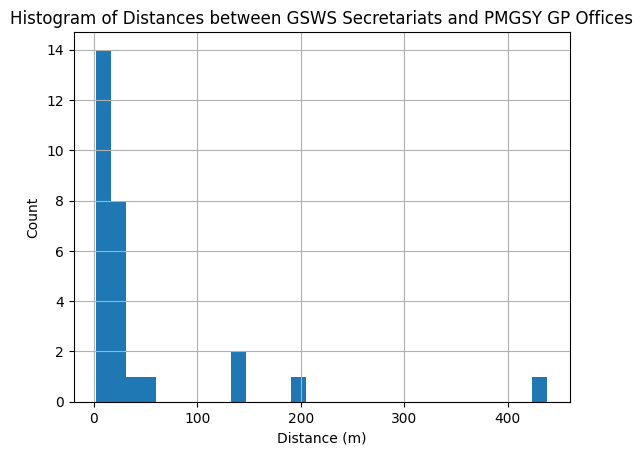

In [20]:
# round distance_m to integers
merged_gdf["distance_m"] = merged_gdf["distance_m"].round(0).astype('Int64')    
# plot histogram of distance_m
merged_gdf["distance_m"].hist(bins=30)
plt.xlabel("Distance (m)")
plt.ylabel("Count")
plt.title("Histogram of Distances between GSWS Secretariats and PMGSY GP Offices")
plt.show()

In [21]:
# print mean, median, max, min of distance_m
print("Distance Statistics (m):")
# print count of non-null distance_m
print(f"Count: {merged_gdf['distance_m'].count()}")
print(f"Mean: {merged_gdf['distance_m'].mean():.2f}")
print(f"Median: {merged_gdf['distance_m'].median():.2f}")
print(f"Max: {merged_gdf['distance_m'].max():.2f}")
print(f"Min: {merged_gdf['distance_m'].min():.2f}") 

Distance Statistics (m):
Count: 28
Mean: 48.25
Median: 16.50
Max: 438.00
Min: 2.00


In [22]:
# change the proejction back to EPSG:4326
merged_gdf = merged_gdf.to_crs(epsg=4326)

# show the row with max value of distance_m in merged_gdf  
merged_gdf[merged_gdf["distance_m"] == merged_gdf["distance_m"].max()]

,osm_type,osm_id,tags,geometry,name,ref,place_name,index_right,State,District,...,Habitation Name,Habitation ID,Facility Name,Address,File Upload Date,Facility Category,Facility Subcategory,Lattitude,Longitude,distance_m
9,node,9731590272,"{'government': 'administrative', 'name': 'Gram...",POINT (79.90586 16.54273),"Grama Sachivalayam, Pillutla-1",GSWS:10790809,Pillutla-1,6253.0,Andhra Pradesh,Guntur,...,Pillutla,852024.0,Gp office,Village Road,2019-09-05 19:46:41.650,Transport/Admin,Panchayat Headquarter,16.539224,79.903938,438


In [23]:
# compute Similartiy between place_name and "Habitation Name" after tranforming to lowercase using difflib SequenceMatcher as a ratio in new column "name_similarity" of merged_gdf            
from difflib import SequenceMatcher

def compute_similarity(name, habitation_name):
    return SequenceMatcher(None, name.lower(), habitation_name.lower()).ratio()
merged_gdf["name_similarity"] = merged_gdf.apply(lambda row: compute_similarity(row["place_name"], row["Habitation Name"]), axis=1)

In [25]:
# show data sorted by name_similarity ascending
merged_gdf.sort_values(by="name_similarity", ascending=True)[["place_name", "Habitation Name", "name_similarity", "distance_m"]]

,place_name,Habitation Name,name_similarity,distance_m
19,S.N.Gollapalem,sultanagaramgollapalem,0.666667,47
26,Chigili-1,Chigeli,0.750000,16
25,Biccavole-1,Biccavolu,0.800000,147
9,Pillutla-1,Pillutla,0.888889,438
23,Yenamalakuduru-1,Enamalakuduru,0.896552,2
7,Vemulavada,Vemulawada,0.900000,10
24,Penumadam-1,Penumadam,0.900000,17
21,Asakapalle,Asakapalli,0.900000,11
14,Dasegownur,Dasegowniyur,0.909091,25
22,Nidamanuru-1,Nidamanuru,0.909091,15
